In [26]:
import pandas as pd
from mendeleev.fetch import fetch_table
import re
import numpy as np

In [27]:
data_df = pd.read_csv("20240124.csv")
elem_df = fetch_table("elements")
elem_df['symbol']

0       H
1      He
2      Li
3      Be
4       B
       ..
113    Fl
114    Mc
115    Lv
116    Ts
117    Og
Name: symbol, Length: 118, dtype: object

In [28]:
def parse_sample(data):
    parsed_data = []
    elem_df = fetch_table("elements")
    all_elems = elem_df['symbol']
    pat = re.compile("|".join(all_elems.tolist()))
    for s, sample in data.iterrows():
        comp = sample["True Composition"]
        match = re.findall(pat, comp)
        stoich = re.split(pat, comp)[1:]
        dix = {}
        dix["Space Group"] = sample["Space group number"]
        dix["a"] = sample["a"]
        dix["b"] = sample["b"]
        dix["c"] = sample["c"]
        dix["alpha"] = sample["alpha"]
        dix["beta"] = sample["beta"]
        dix["gamma"] = sample["gamma"]
        for e in all_elems:
            dix[e] = 0
        for e, f in zip(match, stoich):
            match = re.match(r"([a-z]+)([0-9]+)", f, re.I)
            if match:
                items = match.groups()
                dix[e + items[0]] = float(items[1])
            else:
                dix[e] = float(f)
        dix["IC"] = sample["Ionic conductivity (S cm-1)"]
        parsed_data.append(dix)

    return pd.DataFrame(parsed_data)
    

In [29]:
final = parse_sample(data_df)
final
final.to_csv("20240124v1.csv", index=False)

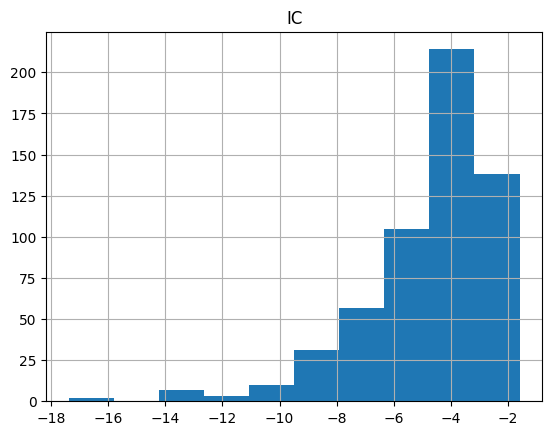

In [30]:
# room temperature ionic conductivities
# remove from all splits, but use proxy on them later
# remove "< 1e-8"
# remove "remove < 1e-10"

# thresh = 1e-8
# final.loc[final["IC"] < thresh, "IC"] = thresh
final["IC"] = np.log10(final["IC"])
final.hist(column=["IC"])

# final.drop(columns=["IC"], axis=1)
fill_cols = (final != 0).any(axis=0)
temp = final.loc[:, fill_cols]
temp.to_csv("20240124v2.csv")

In [31]:
elem_ser = elem_df["symbol"]
print([f for f in final.columns[fill_cols][7:-1]])
atomic_nums = [elem_ser[elem_ser == f].index.values[0] for f in final.columns[fill_cols][7:-1]]
print(atomic_nums)

['H', 'Li', 'B', 'C', 'N', 'O', 'F', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Cu', 'Zn', 'Ga', 'Ge', 'Se', 'Br', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Er', 'Lu', 'Hf', 'Ta', 'W', 'Bi']
[0, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 33, 34, 37, 38, 39, 40, 41, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 61, 67, 70, 71, 72, 73, 82]
